# How Do NBA Head Coaching Changes Influence Team Performance?

## Introduction

The purpose of this project is to investigate the impact of head coach changes on underperforming NBA teams. In the NBA, head coaches are at the forefront of critique when a team underperforms. This usually results in a change of head coaching and, sometimes, the entire coaching staff; but, how effective is this strategy? This project aims to analyze the tangible effects of such coaching transitions on team performance in the subsequent seasons. My focus is on providing a data-driven exploration of the role head coaches play in the NBA and how these changes may influence the team's future performance.

At the end of the 2022-2023 regular season, the Toronto Raptors placed 9th in the Eastern Conference Standings, marking their 2nd missed playoffs in the 3 seasons subsequent to their 2019 Championship run. This led the Raptors parting ways with head coach Nick Nurse as well with the majority of the coaching staff in the summer of 2023. This season, the Raptors hired Darko Rajakovic, an assistant coach from the Memphis Grizzlies to be their new head coach to implement new systems, offensive and defensive philosophies, and to facilitate development of the young Toronto Raptors core.

Coming off high anticipation after the offseason, the Toronto Raptors are 2-4 to start the season. This raises the question: What level of impact can we relaistically expect from these coaching changes? This scenario provides a real-world backdrop for our comprehensive investigation intot he effects of coaching transitions across the NBA.

We seek to answer several questions through exploratory data analysis (EDA):

What is the average number of playoffs clinched within the first 3 years by teams that undergo head coaching changes? How does changing the head coach correlate with the average change in team win percentage in subsequent years? We will also delve into predictive modeling using neural networks (NN). The NN will help us predict the team's future win percentage and determine which seed they could potentially secure in their respective conference. Furthermore, we aim to predict the winningness of the team in subsequent years based on their regular-season records. These predictions will be categorized into:

- High seed team (1-4)
- Low seed team (5-8)
- Out of playoff contention

We can also measure a team's winningness by measuring playoff performance, predicting whether they will:

- Win a championship
- Clinch the conference finals
- Clinch the playoffs

Through this project, we aim to provide data-driven insights into the impact of coaching changes on NBA teams and their future performance, shedding light on the strategies employed in the dynamic world of professional basketball.

## Data Sources

This project uses [Swar's NBA API](https://github.com/swar/nba_api) for the acquisition of data accessible through https://stats.nba.com.

## Collecting the Data

In this section I'll be using the API to collect the data and construct the reporting table.  

In [106]:
# Importing libraries and API endpoints

import pandas as pd
from nba_api.stats.endpoints import commonteamroster
from nba_api.stats.static import teams
from nba_api.stats.endpoints import playoffpicture
from nba_api.stats.endpoints import teamdetails

import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error
import optuna
import matplotlib.pyplot as plt
from nba_api.stats.endpoints import teamestimatedmetrics

In [107]:
# Get a list of team info
team_info = teams.get_teams()
head_coaches_data = []

# Iterate through teams and seasons
for team in team_info:
    team_id = team['id']
    team_name = team['abbreviation']
    for season in range(2005, 2024):
        coach_data = commonteamroster.CommonTeamRoster(team_id=team_id, season=season)
        coach_data_df = coach_data.coaches.get_data_frame()
        seasons = f"{season}-{str(season+1)[-2:]}"
        if not coach_data_df.empty:
            try:
                coach_name = coach_data_df[coach_data_df['COACH_TYPE'] == 'Head Coach']['COACH_NAME'].values[0]
            except IndexError:
                coach_name = 'None'
        head_coaches_data.append({
            'Team ID': team_id,
            'Season': seasons,
            'Team': team_name,
            'Coach': coach_name
        })

head_coaches_df = pd.DataFrame(head_coaches_data)

In [3]:
no_data = head_coaches_df[head_coaches_df['Coach'] == 'None']
no_data

,Team ID,Season,Team,Coach
66,1610612740,2014-15,NOP,None
121,1610612743,2012-13,DEN,None
200,1610612747,2015-16,LAL,None
349,1610612755,2012-13,PHI,None
374,1610612756,2018-19,PHX,None
409,1610612758,2015-16,SAC,None
446,1610612760,2014-15,OKC,None
567,1610612766,2021-22,CHA,None


In [108]:
playoff_picture_df = pd.DataFrame(columns=['Season', 'Seed', 'Team ID', 'Wins', 'Losses', 'Win PCT', 'Clinched Playoffs', 'Clinched Conference'])

for season in range(2005, 2024):
    playoff_picture = playoffpicture.PlayoffPicture(season_id='2' + str(season))

    EastConfStandings_df = playoff_picture.east_conf_standings.get_data_frame()
    EastConfPlayoffPicture_df = playoff_picture.east_conf_playoff_picture.get_data_frame()
    east_team_wins = EastConfStandings_df['WINS']
    east_team_losses = EastConfStandings_df['LOSSES']
    east_team_seed = EastConfPlayoffPicture_df['HIGH_SEED_RANK'].combine_first(EastConfPlayoffPicture_df['LOW_SEED_RANK'])
    east_team_pct = EastConfStandings_df['PCT']
    #east_team = EastConfStandings_df['TEAM']
    east_team_id = EastConfStandings_df['TEAM_ID']
    east_team_clinched_playoffs = EastConfStandings_df['CLINCHED_PLAYOFFS']
    east_team_clinched_conference = EastConfStandings_df['CLINCHED_CONFERENCE']

    east_df = pd.DataFrame({
        'Season': f"{season}-{str(season+1)[-2:]}",
        'Team ID': east_team_id,
        'Wins': east_team_wins,
        'Losses': east_team_losses, 
        'Win PCT': east_team_pct,
        'Clinched Playoffs': east_team_clinched_playoffs,
        'Clinched Conference': east_team_clinched_conference
        })
    
    WestConfStandings_df = playoff_picture.west_conf_standings.get_data_frame()
    WestConfPlayoffPicture_df = playoff_picture.west_conf_playoff_picture.get_data_frame()
    west_team_wins = WestConfStandings_df['WINS']
    west_team_losses = WestConfStandings_df['LOSSES']
    west_team_pct = WestConfStandings_df['PCT']
    #west_team = WestConfStandings_df['TEAM']
    west_team_id = WestConfStandings_df['TEAM_ID']
    west_team_clinched_playoffs = WestConfStandings_df['CLINCHED_PLAYOFFS']
    west_team_clinched_conference = WestConfStandings_df['CLINCHED_CONFERENCE']

    west_df = pd.DataFrame({
        'Season': f"{season}-{str(season+1)[-2:]}",
        'Team ID': west_team_id,
        'Wins': west_team_wins,
        'Losses': west_team_losses, 
        'Win PCT': west_team_pct,
        'Clinched Playoffs': west_team_clinched_playoffs,
        'Clinched Conference': west_team_clinched_conference
        })
    east_df.reset_index(drop=True, inplace=True)
    west_df.reset_index(drop=True, inplace=True)

    east_df['Seed'] = east_df.index + 1
    west_df['Seed'] = west_df.index + 1

    playoff_picture_df = pd.concat([playoff_picture_df, east_df, west_df])

playoff_picture_df.head(5)

,Season,Seed,Team ID,Wins,Losses,Win PCT,Clinched Playoffs,Clinched Conference
0,2005-06,1,1610612765,64,18,0.780,1,1
1,2005-06,2,1610612748,52,30,0.634,1,0
2,2005-06,3,1610612739,50,32,0.610,1,0
3,2005-06,4,1610612751,49,33,0.598,1,0
4,2005-06,5,1610612764,42,40,0.512,1,0


In [109]:
data = []
teams = teams.get_teams()
team_id = [team['id'] for team in teams]
all_seasons = [f"{year - 1}-{str(year)[-2:]}" for year in range(2005, 2024)]

for id in team_id:
    champ = teamdetails.TeamDetails(team_id=id)
    champ_df = champ.team_awards_championships.get_data_frame()
    
    if 'YEARAWARDED' in champ_df:
        won_titles = champ_df[champ_df['YEARAWARDED'] >= 2005]
        if not won_titles.empty:
            seasons = won_titles['YEARAWARDED'].apply(lambda year: f"{year - 1}-{str(year)[-2:]}")
            data.extend([(id, season, 1) for season in seasons])

# Fill in missing entries with 0
for id in team_id:
    for season in all_seasons:
        if not any((entry[0] == id and entry[1] == season) for entry in data):
            data.append((id, season, 0))

title_df = pd.DataFrame(data, columns=['Team ID', 'Season', 'Won Title'])
title_df.head(5)

,Team ID,Season,Won Title
0,1610612738,2007-08,1
1,1610612739,2015-16,1
2,1610612742,2010-11,1
3,1610612743,2022-23,1
4,1610612744,2014-15,1


In [110]:
combined_df = pd.merge(head_coaches_df, playoff_picture_df, on=['Team ID', 'Season'], how='left')
combined_df = pd.merge(combined_df, title_df, how='left')
combined_df = combined_df.sort_values(by='Season')
combined_df.head(5)

,Team ID,Season,Team,Coach,Seed,Wins,Losses,Win PCT,Clinched Playoffs,Clinched Conference,Won Title
0,1610612737,2005-06,ATL,Mike Woodson,14,26,56,0.317,0,0,0.0
437,1610612760,2005-06,OKC,Bob Hill,11,35,47,0.427,0,0,0.0
38,1610612739,2005-06,CLE,Mike Brown,3,50,32,0.610,1,0,0.0
418,1610612759,2005-06,SAS,Gregg Popovich,1,63,19,0.768,1,1,0.0
399,1610612758,2005-06,SAC,Rick Adelman,8,44,38,0.537,1,0,0.0


## Feature Engineering

**v1 (Current)**
- Coach experience (YoE)
- Coach track record (W/L)
- Historical team performance (T-3 seasons average)

v2
- Player stats

In [232]:
# Creating a seed type for classification

seed_data = []

for seed in combined_df.Seed:
    if seed < 5: 
        seed_data.append(1) # seeds 1-4
    elif seed < 9: 
        seed_data.append(2) # seeds 5-8
    else:
        seed_data.append(3) # below 8th seed

In [233]:
# combined_df.drop(columns='Seed Type')
combined_df.insert(5, 'Seed Type', seed_data)
combined_df.head(5)

,Team ID,Season,Team,Coach,Seed,Seed Type,Wins,Losses,Win PCT,Clinched Playoffs,Clinched Conference,Won Title,Avg Wins T-5 Seasons,Avg Losses T-5 Seasons,Avg Win PCT T-5 Seasons,Agg. Coach Wins,Agg. Coach Losses,Coach Experience,Agg. Playoffs Coached,Agg. Conference Finals Coached,Agg. Coach Titles Won,Running Avg. Est. OFFRTG,Running Avg. Est. DEFRTG,Running Avg. Est. PACE,Running Avg. Est. AST RATIO,Running Avg. Est. OREB PCT,Running Avg. Est. DREB PCT,Running Avg. Est. REB PCT,Running Avg. Est. TM TOV PCT
0,1610612737,2005-06,ATL,Mike Woodson,14,3,26,56,0.317,0,0,0.0,NaN,NaN,NaN,26,56,1,0,0,0.0,109.40,102.900000,98.100,19.500000,0.221000,0.7210,0.4770,0.1340
1,1610612737,2006-07,ATL,Mike Woodson,13,3,30,52,0.366,1,0,0.0,NaN,NaN,NaN,56,108,2,1,0,0.0,106.10,102.500000,97.350,18.550000,0.244500,0.7205,0.4870,0.1430
2,1610612737,2007-08,ATL,Mike Woodson,8,2,37,45,0.451,1,0,0.0,NaN,NaN,NaN,93,153,3,2,0,0.0,103.90,103.066667,96.900,17.666667,0.253333,0.7160,0.4830,0.1440
3,1610612737,2008-09,ATL,Mike Woodson,4,1,47,35,0.573,1,0,0.0,NaN,NaN,NaN,140,188,4,3,0,0.0,103.40,103.175000,96.625,17.225000,0.257250,0.7160,0.4840,0.1445
4,1610612737,2009-10,ATL,Mike Woodson,3,1,53,29,0.646,1,0,0.0,38.6,43.4,0.4706,193,217,5,4,0,0.0,102.98,102.580000,96.440,17.160000,0.258400,0.7222,0.4884,0.1466


In [114]:
num_prev_seasons = 5

combined_df_sortavg = combined_df.sort_values(by = ['Season', 'Team'])
combined_df['Avg Wins T-5 Seasons'] = combined_df_sortavg.groupby('Team')['Wins'].rolling(window=num_prev_seasons).mean().reset_index(0, drop=True)
combined_df['Avg Losses T-5 Seasons'] = combined_df_sortavg.groupby('Team')['Losses'].rolling(window=num_prev_seasons).mean().reset_index(0, drop=True)
combined_df['Avg Win PCT T-5 Seasons'] = combined_df_sortavg.groupby('Team')['Win PCT'].rolling(window=num_prev_seasons).mean().reset_index(0, drop=True)

combined_df['Wins'] = pd.to_numeric(combined_df['Wins'], errors='coerce')
combined_df['Losses'] = pd.to_numeric(combined_df['Losses'], errors='coerce')

for index, won_title in combined_df['Won Title'].items():
    if pd.isna(won_title):
        combined_df.at[index, 'Won Title'] = 0

combined_df.head(5)

,Team ID,Season,Team,Coach,Seed,Wins,Losses,Win PCT,Clinched Playoffs,Clinched Conference,Won Title,Avg Wins T-5 Seasons,Avg Losses T-5 Seasons,Avg Win PCT T-5 Seasons
0,1610612737,2005-06,ATL,Mike Woodson,14,26,56,0.317,0,0,0.0,NaN,NaN,NaN
437,1610612760,2005-06,OKC,Bob Hill,11,35,47,0.427,0,0,0.0,NaN,NaN,NaN
38,1610612739,2005-06,CLE,Mike Brown,3,50,32,0.610,1,0,0.0,NaN,NaN,NaN
418,1610612759,2005-06,SAS,Gregg Popovich,1,63,19,0.768,1,1,0.0,NaN,NaN,NaN
399,1610612758,2005-06,SAC,Rick Adelman,8,44,38,0.537,1,0,0.0,NaN,NaN,NaN


In [358]:
# Had to manually fix some bad data from earlier

import os
path = os.getcwd()
#combined_df.to_csv('/Users/kelvin/Documents/projects-learning/repositories/sports-analytics/coaches.csv', index=False)

In [153]:
coaches_fixed_df = pd.read_csv('/Users/kelvin/Documents/projects-learning/repositories/sports-analytics/coaches.csv')
coaches_df = coaches_fixed_df['Coach']

coaches_df.reset_index(drop=True, inplace=True)

In [194]:
# combined_df_coachagg = combined_df.sort_values(by = ['Team', 'Season'])
# combined_df_coachagg.reset_index(drop=True, inplace=True)

# combined_df = combined_df.drop(columns='Coach')
# combined_df_coachagg = combined_df_coachagg.drop(columns='Coach')
# combined_df_coachagg.insert(loc=3, column='Coach', value=coaches_df)

combined_df_coachagg.head(10)

,Team ID,Season,Team,Coach,Seed,Wins,Losses,Win PCT,Clinched Playoffs,Clinched Conference,Won Title,Avg Wins T-5 Seasons,Avg Losses T-5 Seasons,Avg Win PCT T-5 Seasons
0,1610612737,2005-06,ATL,Mike Woodson,14,26,56,0.317,0,0,0.0,NaN,NaN,NaN
1,1610612737,2006-07,ATL,Mike Woodson,13,30,52,0.366,1,0,0.0,NaN,NaN,NaN
2,1610612737,2007-08,ATL,Mike Woodson,8,37,45,0.451,1,0,0.0,NaN,NaN,NaN
3,1610612737,2008-09,ATL,Mike Woodson,4,47,35,0.573,1,0,0.0,NaN,NaN,NaN
4,1610612737,2009-10,ATL,Mike Woodson,3,53,29,0.646,1,0,0.0,38.6,43.4,0.4706
5,1610612737,2010-11,ATL,Larry Drew,5,44,38,0.537,1,0,0.0,42.2,39.8,0.5146
6,1610612737,2011-12,ATL,Larry Drew,5,40,26,0.606,1,0,0.0,44.2,34.6,0.5626
7,1610612737,2012-13,ATL,Larry Drew,6,44,38,0.537,1,0,0.0,45.6,33.2,0.5798
8,1610612737,2013-14,ATL,Mike Budenholzer,8,38,44,0.463,1,0,0.0,43.8,35.0,0.5578
9,1610612737,2014-15,ATL,Mike Budenholzer,1,60,22,0.732,1,1,0.0,45.2,33.6,0.5750


In [149]:
all_tem_df = pd.DataFrame()

for season in range(2005, 2024):
    tem = teamestimatedmetrics.TeamEstimatedMetrics(season=f"{season}-{str(season+1)[-2:]}").team_estimated_metrics
    tem_df = tem.get_data_frame()[['TEAM_NAME', 'TEAM_ID', 'E_OFF_RATING', 'E_DEF_RATING', 'E_NET_RATING', 'E_PACE', 'E_AST_RATIO', 'E_OREB_PCT', 'E_DREB_PCT', 'E_REB_PCT', 'E_TM_TOV_PCT']]

    tem_df['Season'] = f"{season}-{str(season+1)[-2:]}"
    all_tem_df = pd.concat([all_tem_df, tem_df], ignore_index=True)

all_tem_df = pd.concat([all_tem_df['Season'], all_tem_df.drop('Season', axis=1)], axis=1)
all_tem_df = all_tem_df.sort_values(by=['TEAM_NAME', 'Season'])
all_tem_df.head(10)

,Season,TEAM_NAME,TEAM_ID,E_OFF_RATING,E_DEF_RATING,E_NET_RATING,E_PACE,E_AST_RATIO,E_OREB_PCT,E_DREB_PCT,E_REB_PCT,E_TM_TOV_PCT
16,2005-06,Atlanta Hawks,1610612737,103.8,108.3,-4.5,93.0,15.5,0.314,0.695,0.499,0.167
53,2006-07,Atlanta Hawks,1610612737,100.1,105.5,-5.3,92.5,15.3,0.292,0.709,0.498,0.170
77,2007-08,Atlanta Hawks,1610612737,104.0,105.9,-2.0,93.6,17.0,0.297,0.717,0.508,0.158
113,2008-09,Atlanta Hawks,1610612737,106.6,104.6,2.0,92.0,16.4,0.260,0.716,0.489,0.139
146,2009-10,Atlanta Hawks,1610612737,108.9,104.0,4.9,92.5,17.1,0.282,0.727,0.502,0.128
176,2010-11,Atlanta Hawks,1610612737,103.2,104.6,-1.4,91.6,17.7,0.234,0.746,0.492,0.148
202,2011-12,Atlanta Hawks,1610612737,102.4,98.6,3.8,92.5,17.6,0.239,0.744,0.493,0.148
222,2012-13,Atlanta Hawks,1610612737,102.7,101.8,0.9,94.7,18.8,0.222,0.736,0.483,0.156
252,2013-14,Atlanta Hawks,1610612737,103.4,104.1,-0.7,96.9,18.8,0.210,0.744,0.479,0.156
284,2014-15,Atlanta Hawks,1610612737,106.2,100.7,5.6,96.2,19.5,0.214,0.734,0.482,0.147


In [ ]:
#combined_df_coachagg = pd.concat([combined_df_coachagg, all_tem_df[['E_OFF_RATING', 'E_DEF_RATING', 'E_PACE', 'E_AST_RATIO', 'E_OREB_PCT', 'E_DREB_PCT', 'E_REB_PCT', 'E_TM_TOV_PCT']]])
#combined_df_coachagg = pd.concat([combined_df_coachagg, all_tem_df[['E_OFF_RATING', 'E_DEF_RATING', 'E_PACE', 'E_AST_RATIO', 'E_OREB_PCT', 'E_DREB_PCT', 'E_REB_PCT', 'E_TM_TOV_PCT']]], axis=1)
combined_df_coachagg

In [219]:
columns_to_numeric = ['Clinched Playoffs', 
                      'Clinched Conference', 
                      'Won Title', 
                      'E_OFF_RATING', 
                      'E_DEF_RATING', 
                      'E_PACE', 
                      'E_AST_RATIO', 
                      'E_OREB_PCT', 
                      'E_DREB_PCT', 
                      'E_REB_PCT', 
                      'E_TM_TOV_PCT']
combined_df_coachagg[columns_to_numeric] = combined_df_coachagg[columns_to_numeric].apply(pd.to_numeric, errors='coerce')


In [220]:
combined_df_coachagg['Running Avg. Est. OFFRTG'] = combined_df_coachagg.groupby('Coach')['E_OFF_RATING'].expanding().mean().reset_index(level=0, drop=True)
combined_df_coachagg['Running Avg. Est. DEFRTG'] = combined_df_coachagg.groupby('Coach')['E_DEF_RATING'].expanding().mean().reset_index(level=0, drop=True)
combined_df_coachagg['Running Avg. Est. PACE'] = combined_df_coachagg.groupby('Coach')['E_PACE'].expanding().mean().reset_index(level=0, drop=True)
combined_df_coachagg['Running Avg. Est. AST RATIO'] = combined_df_coachagg.groupby('Coach')['E_AST_RATIO'].expanding().mean().reset_index(level=0, drop=True)
combined_df_coachagg['Running Avg. Est. OREB PCT'] = combined_df_coachagg.groupby('Coach')['E_OREB_PCT'].expanding().mean().reset_index(level=0, drop=True)
combined_df_coachagg['Running Avg. Est. DREB PCT'] = combined_df_coachagg.groupby('Coach')['E_DREB_PCT'].expanding().mean().reset_index(level=0, drop=True)
combined_df_coachagg['Running Avg. Est. REB PCT'] = combined_df_coachagg.groupby('Coach')['E_REB_PCT'].expanding().mean().reset_index(level=0, drop=True)
combined_df_coachagg['Running Avg. Est. TM TOV PCT'] = combined_df_coachagg.groupby('Coach')['E_TM_TOV_PCT'].expanding().mean().reset_index(level=0, drop=True)

combined_df_coachagg['Agg. Coach Wins'] = combined_df_coachagg.groupby('Coach')['Wins'].cumsum()
combined_df_coachagg['Agg. Coach Losses'] = combined_df_coachagg.groupby('Coach')['Losses'].cumsum()
combined_df_coachagg['Helper'] = 1
combined_df_coachagg['Coach Experience'] = combined_df_coachagg.groupby('Coach')['Helper'].cumsum()
combined_df_coachagg['Agg. Playoffs Coached'] = combined_df_coachagg.groupby('Coach')['Clinched Playoffs'].cumsum()
combined_df_coachagg['Agg. Conference Finals Coached'] = combined_df_coachagg.groupby('Coach')['Clinched Conference'].cumsum()
combined_df_coachagg['Agg. Coach Titles Won'] = combined_df_coachagg.groupby('Coach')['Won Title'].cumsum()

combined_df_coachagg['New Coach'] = combined_df_coachagg.groupby('Team')['Coach'].transform(lambda x: x.ne(x.shift()))

combined_df_coachagg.head(10)

,Team ID,Season,Team,Coach,Seed,Wins,Losses,Win PCT,Clinched Playoffs,Clinched Conference,Won Title,Avg Wins T-5 Seasons,Avg Losses T-5 Seasons,Avg Win PCT T-5 Seasons,E_OFF_RATING,E_DEF_RATING,E_PACE,E_AST_RATIO,E_OREB_PCT,E_DREB_PCT,E_REB_PCT,E_TM_TOV_PCT,Running Avg. Est. OFFRTG,Running Avg. Est. DEFRTG,Running Avg. Est. PACE,Running Avg. Est. AST RATIO,Running Avg. Est. OREB PCT,Running Avg. Est. DREB PCT,Running Avg. Est. REB PCT,Running Avg. Est. TM TOV PCT,New Coach,Agg. Coach Wins,Agg. Coach Losses,Helper,Coach Experience,Agg. Playoffs Coached,Agg. Conference Finals Coached,Agg. Coach Titles Won
0,1610612737,2005-06,ATL,Mike Woodson,14,26,56,0.317,0,0,0.0,NaN,NaN,NaN,109.4,102.9,98.1,19.5,0.221,0.721,0.477,0.134,109.400000,102.900000,98.100,19.500000,0.221000,0.721000,0.477000,0.134000,True,26,56,1,1,0,0,0.0
1,1610612737,2006-07,ATL,Mike Woodson,13,30,52,0.366,1,0,0.0,NaN,NaN,NaN,102.8,102.1,96.6,17.6,0.268,0.720,0.497,0.152,106.100000,102.500000,97.350,18.550000,0.244500,0.720500,0.487000,0.143000,False,56,108,1,2,1,0,0.0
2,1610612737,2007-08,ATL,Mike Woodson,8,37,45,0.451,1,0,0.0,NaN,NaN,NaN,99.5,104.2,96.0,15.9,0.271,0.707,0.475,0.146,103.900000,103.066667,96.900,17.666667,0.253333,0.716000,0.483000,0.144000,False,93,153,1,3,2,0,0.0
3,1610612737,2008-09,ATL,Mike Woodson,4,47,35,0.573,1,0,0.0,NaN,NaN,NaN,101.9,103.5,95.8,15.9,0.269,0.716,0.487,0.146,103.400000,103.175000,96.625,17.225000,0.257250,0.716000,0.484000,0.144500,False,140,188,1,4,3,0,0.0
4,1610612737,2009-10,ATL,Mike Woodson,3,53,29,0.646,1,0,0.0,38.6,43.4,0.4706,101.3,100.2,95.7,16.9,0.263,0.747,0.506,0.155,102.980000,102.580000,96.440,17.160000,0.258400,0.722200,0.488400,0.146600,False,193,217,1,5,4,0,0.0
5,1610612737,2010-11,ATL,Larry Drew,5,44,38,0.537,1,0,0.0,42.2,39.8,0.5146,103.7,104.8,95.1,15.8,0.256,0.713,0.485,0.148,103.700000,104.800000,95.100,15.800000,0.256000,0.713000,0.485000,0.148000,True,44,38,1,1,1,0,0.0
6,1610612737,2011-12,ATL,Larry Drew,5,40,26,0.606,1,0,0.0,44.2,34.6,0.5626,106.0,104.7,94.9,14.5,0.295,0.709,0.495,0.145,104.850000,104.750000,95.000,15.150000,0.275500,0.711000,0.490000,0.146500,False,84,64,1,2,2,0,0.0
7,1610612737,2012-13,ATL,Larry Drew,6,44,38,0.537,1,0,0.0,45.6,33.2,0.5798,102.5,104.0,94.7,16.4,0.255,0.728,0.497,0.173,104.066667,104.500000,94.900,15.566667,0.268667,0.716667,0.492333,0.155333,False,128,102,1,3,3,0,0.0
8,1610612737,2013-14,ATL,Mike Budenholzer,8,38,44,0.463,1,0,0.0,43.8,35.0,0.5578,107.4,111.3,94.5,16.0,0.304,0.690,0.494,0.154,107.400000,111.300000,94.500,16.000000,0.304000,0.690000,0.494000,0.154000,True,38,44,1,1,1,0,0.0
9,1610612737,2014-15,ATL,Mike Budenholzer,1,60,22,0.732,1,1,0.0,45.2,33.6,0.5750,103.9,102.3,94.4,17.3,0.254,0.722,0.490,0.154,105.650000,106.800000,94.450,16.650000,0.279000,0.706000,0.492000,0.154000,False,98,66,1,2,2,1,0.0


In [221]:
combined_df = combined_df.sort_values(['Team', 'Season'])
combined_df.reset_index(drop=True, inplace=True)
combined_df = combined_df.drop(columns='Coach')
combined_df.head(5)

KeyError: "['Coach'] not found in axis"

In [224]:
# combined_df.insert(3, 'Coach', combined_df_coachagg['Coach'])
combined_df['Agg. Coach Wins'] = combined_df_coachagg['Agg. Coach Wins']
combined_df['Agg. Coach Losses'] = combined_df_coachagg['Agg. Coach Losses']
combined_df['Coach Experience'] = combined_df_coachagg['Coach Experience']
combined_df['Agg. Playoffs Coached'] = combined_df_coachagg['Agg. Playoffs Coached']
combined_df['Agg. Conference Finals Coached'] = combined_df_coachagg['Agg. Conference Finals Coached']
combined_df['Agg. Coach Titles Won'] = combined_df_coachagg['Agg. Coach Titles Won']
combined_df['Running Avg. Est. OFFRTG'] = combined_df_coachagg['Running Avg. Est. OFFRTG'] 
combined_df['Running Avg. Est. DEFRTG'] = combined_df_coachagg['Running Avg. Est. DEFRTG']
combined_df['Running Avg. Est. PACE']  = combined_df_coachagg['Running Avg. Est. PACE'] 
combined_df['Running Avg. Est. AST RATIO'] = combined_df_coachagg['Running Avg. Est. AST RATIO']
combined_df['Running Avg. Est. OREB PCT'] = combined_df_coachagg['Running Avg. Est. OREB PCT']
combined_df['Running Avg. Est. DREB PCT'] = combined_df_coachagg['Running Avg. Est. DREB PCT']
combined_df['Running Avg. Est. REB PCT'] = combined_df_coachagg['Running Avg. Est. REB PCT']
combined_df['Running Avg. Est. TM TOV PCT'] = combined_df_coachagg['Running Avg. Est. TM TOV PCT']

In [225]:
combined_df.head(10)

,Team ID,Season,Team,Coach,Seed,Wins,Losses,Win PCT,Clinched Playoffs,Clinched Conference,Won Title,Avg Wins T-5 Seasons,Avg Losses T-5 Seasons,Avg Win PCT T-5 Seasons,Agg. Coach Wins,Agg. Coach Losses,Coach Experience,Agg. Playoffs Coached,Agg. Conference Finals Coached,Agg. Coach Titles Won,Running Avg. Est. OFFRTG,Running Avg. Est. DEFRTG,Running Avg. Est. PACE,Running Avg. Est. AST RATIO,Running Avg. Est. OREB PCT,Running Avg. Est. DREB PCT,Running Avg. Est. REB PCT,Running Avg. Est. TM TOV PCT
0,1610612737,2005-06,ATL,Mike Woodson,14,26,56,0.317,0,0,0.0,NaN,NaN,NaN,26,56,1,0,0,0.0,109.400000,102.900000,98.100,19.500000,0.221000,0.721000,0.477000,0.134000
1,1610612737,2006-07,ATL,Mike Woodson,13,30,52,0.366,1,0,0.0,NaN,NaN,NaN,56,108,2,1,0,0.0,106.100000,102.500000,97.350,18.550000,0.244500,0.720500,0.487000,0.143000
2,1610612737,2007-08,ATL,Mike Woodson,8,37,45,0.451,1,0,0.0,NaN,NaN,NaN,93,153,3,2,0,0.0,103.900000,103.066667,96.900,17.666667,0.253333,0.716000,0.483000,0.144000
3,1610612737,2008-09,ATL,Mike Woodson,4,47,35,0.573,1,0,0.0,NaN,NaN,NaN,140,188,4,3,0,0.0,103.400000,103.175000,96.625,17.225000,0.257250,0.716000,0.484000,0.144500
4,1610612737,2009-10,ATL,Mike Woodson,3,53,29,0.646,1,0,0.0,38.6,43.4,0.4706,193,217,5,4,0,0.0,102.980000,102.580000,96.440,17.160000,0.258400,0.722200,0.488400,0.146600
5,1610612737,2010-11,ATL,Larry Drew,5,44,38,0.537,1,0,0.0,42.2,39.8,0.5146,44,38,1,1,0,0.0,103.700000,104.800000,95.100,15.800000,0.256000,0.713000,0.485000,0.148000
6,1610612737,2011-12,ATL,Larry Drew,5,40,26,0.606,1,0,0.0,44.2,34.6,0.5626,84,64,2,2,0,0.0,104.850000,104.750000,95.000,15.150000,0.275500,0.711000,0.490000,0.146500
7,1610612737,2012-13,ATL,Larry Drew,6,44,38,0.537,1,0,0.0,45.6,33.2,0.5798,128,102,3,3,0,0.0,104.066667,104.500000,94.900,15.566667,0.268667,0.716667,0.492333,0.155333
8,1610612737,2013-14,ATL,Mike Budenholzer,8,38,44,0.463,1,0,0.0,43.8,35.0,0.5578,38,44,1,1,0,0.0,107.400000,111.300000,94.500,16.000000,0.304000,0.690000,0.494000,0.154000
9,1610612737,2014-15,ATL,Mike Budenholzer,1,60,22,0.732,1,1,0.0,45.2,33.6,0.5750,98,66,2,2,1,0.0,105.650000,106.800000,94.450,16.650000,0.279000,0.706000,0.492000,0.154000


## Seed Type Classification

The seed type classification is based on a straightforward definition:
- Assign a seed type of 1 if the team's seed is in the range of 1 to 4.
- Assign a seed type of 2 if the team's seed is in the range of 5 to 8.
- Assign a seed type of 3 otherwise.

This approach is designed to be:
- Easily predictable: The classification is determined by clear and simple seed ranges.
- Generalizable: The seed type categorization provides a high-level understanding of a team's performance expectations.
- Removes unnecessary complexity while retaining practicality and information: Instead of predicting the exact seed, the focus is on predicting the general type of team a coach is likely to lead in the regular season.

In [226]:
def preprocess_data(data):

    data['Coach'] = LabelEncoder().fit_transform(data['Coach'])
    x = data.drop(columns=['Season', 'Seed', 'Team', 'Wins', 'Losses', 'Win PCT', 'Seed Type', 'Clinched Playoffs', 'Clinched Conference', 'Won Title'])
    y = data['Seed Type']
    
    return x, y

In [240]:
clean_data = combined_df.dropna()
training_data = clean_data[clean_data['Season'] != '2023-24']

x, y = preprocess_data(training_data)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 59.52%


/var/folders/3z/8j8g_lgs5j7b31l1sp39n6380000gn/T/ipykernel_54182/4203988621.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Coach'] = LabelEncoder().fit_transform(data['Coach'])


In [241]:
training_data = clean_data[~clean_data['Season'].isin(['2022-23', '2023-24'])]
test_data = clean_data[clean_data['Season'].isin(['2022-23'])]
x_test_cs, y_test_cs = preprocess_data(test_data)
x_train_cs, y_train_cs = preprocess_data(training_data)

rf_cs = RandomForestClassifier(random_state=42)
rf_cs.fit(x_train_cs, y_train_cs)

y_pred_cs = rf_cs.predict(x_test_cs)
accuracy_cs = accuracy_score(y_test_cs, y_pred_cs)
print(f"Accuracy: {accuracy_cs * 100:.2f}%")

/var/folders/3z/8j8g_lgs5j7b31l1sp39n6380000gn/T/ipykernel_54182/4203988621.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Coach'] = LabelEncoder().fit_transform(data['Coach'])
/var/folders/3z/8j8g_lgs5j7b31l1sp39n6380000gn/T/ipykernel_54182/4203988621.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Coach'] = LabelEncoder().fit_transform(data['Coach'])


Accuracy: 63.33%


In [242]:
previous_season_predictions = test_data
#current_season_predictions.reset_index(drop=True, inplace=True)

In [243]:
#current_season_predictions = current_season_predictions.drop(columns='Seed Type Prediction (RF)')
previous_season_predictions.insert(6, 'Seed Type Prediction (RF)', y_pred_cs)
previous_season_predictions

,Team ID,Season,Team,Coach,Seed,Seed Type,Seed Type Prediction (RF),Wins,Losses,Win PCT,Clinched Playoffs,Clinched Conference,Won Title,Avg Wins T-5 Seasons,Avg Losses T-5 Seasons,Avg Win PCT T-5 Seasons,Agg. Coach Wins,Agg. Coach Losses,Coach Experience,Agg. Playoffs Coached,Agg. Conference Finals Coached,Agg. Coach Titles Won,Running Avg. Est. OFFRTG,Running Avg. Est. DEFRTG,Running Avg. Est. PACE,Running Avg. Est. AST RATIO,Running Avg. Est. OREB PCT,Running Avg. Est. DREB PCT,Running Avg. Est. REB PCT,Running Avg. Est. TM TOV PCT
17,1610612737,2022-23,ATL,19,8,2,3,41,41,0.500,0,0,0.0,34.8,42.2,0.4492,41,41,1,0,0,0.0,105.200000,102.600000,92.200000,15.300000,0.284000,0.757000,0.518000,0.149000
36,1610612751,2022-23,BKN,9,6,2,2,45,37,0.549,1,0,0.0,42.8,35.2,0.5502,45,37,1,1,0,0.0,102.500000,97.000000,96.000000,17.000000,0.286000,0.743000,0.516000,0.166000
55,1610612738,2022-23,BOS,12,2,1,1,57,25,0.695,1,0,0.0,48.2,29.8,0.6164,57,25,1,1,0,0.0,102.600000,102.000000,92.100000,16.600000,0.249000,0.733000,0.497000,0.159000
74,1610612766,2022-23,CHA,22,14,3,3,27,55,0.329,0,0,0.0,33.0,43.6,0.4282,223,269,6,2,0,0.0,104.883333,105.483333,96.350000,16.266667,0.255333,0.729000,0.494333,0.152833
93,1610612741,2022-23,CHI,0,10,3,3,40,42,0.488,0,0,0.0,32.2,44.4,0.4172,117,119,3,1,0,0.0,107.300000,107.800000,98.766667,16.566667,0.258333,0.729667,0.494000,0.149333
112,1610612739,2022-23,CLE,8,4,1,2,51,31,0.622,1,0,0.0,31.0,45.6,0.3978,117,119,3,1,0,0.0,103.800000,106.566667,92.366667,15.500000,0.252000,0.733000,0.489667,0.146333
131,1610612742,2022-23,DAL,11,11,3,1,38,44,0.463,0,0,0.0,41.6,37.0,0.5310,134,112,3,2,0,0.0,101.500000,104.533333,93.733333,15.533333,0.272667,0.722000,0.499333,0.155333
150,1610612743,2022-23,DEN,14,1,1,1,53,29,0.646,1,1,1.0,49.6,28.6,0.6346,367,270,8,5,1,1.0,104.162500,104.475000,93.087500,16.062500,0.273875,0.740875,0.505375,0.149125
169,1610612765,2022-23,DET,5,15,3,3,17,65,0.207,0,0,0.0,24.2,52.6,0.3136,121,263,5,1,0,0.0,106.020000,102.500000,93.560000,17.440000,0.262000,0.740400,0.505400,0.147000
188,1610612744,2022-23,GSW,23,6,2,1,44,38,0.537,1,0,0.0,41.6,35.0,0.5302,473,238,9,7,4,4.0,103.300000,102.533333,95.888889,16.200000,0.271778,0.725667,0.499667,0.154778


In [268]:
# using optuna to tune hyperparameters
%%capture 

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_cs)
x_test_scaled = scaler.transform(x_test_cs)

def params(trial):
    max_iter = trial.suggest_categorical('max_iter', [500, 1000])
    learning_rate_init = trial.suggest_uniform('learning_rate_init', 0.001, 0.1)
    hidden_layer_sizes = trial.suggest_int('hidden_layer_sizes', 100, 250)

    nn_clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, learning_rate='adaptive', random_state=42, activation='tanh')
    nn_clf.fit(x_train_cs, y_train_cs)
    y_pred_nn = nn_clf.predict(x_test_scaled)
    accuracy_nn = accuracy_score(y_test_cs, y_pred_nn)

    return accuracy_nn

study = optuna.create_study(direction='maximize')
study.optimize(params, n_trials=250)
best_params = study.best_params

UsageError: Line magic function `%%capture` not found.


In [255]:
nn_model = MLPClassifier(hidden_layer_sizes=(best_params['hidden_layer_sizes'], ), learning_rate_init=best_params['learning_rate_init'], max_iter=best_params['max_iter'], activation='tanh', random_state=42)
nn_model.fit(x_train_scaled, y_train_cs)
y_pred_nn = nn_model.predict(x_test_scaled)

In [258]:
accuracy_nn = accuracy_score(y_test_cs, y_pred_nn)
pred_nn = pd.DataFrame(y_pred_nn)
accuracy_nn

0.6

In [265]:
# previous_season_predictions = previous_season_predictions.drop(columns='Seed Type Prediction (NN)')
previous_season_predictions.insert(7, 'Seed Type Prediction (NN)', pred_nn)
# previous_season_predictions.reset_index(drop=True, inplace=True)
previous_season_predictions

,Team ID,Season,Team,Coach,Seed,Seed Type,Seed Type Prediction (RF),Seed Type Prediction (NN),Wins,Losses,Win PCT,Clinched Playoffs,Clinched Conference,Won Title,Avg Wins T-5 Seasons,Avg Losses T-5 Seasons,Avg Win PCT T-5 Seasons,Agg. Coach Wins,Agg. Coach Losses,Coach Experience,Agg. Playoffs Coached,Agg. Conference Finals Coached,Agg. Coach Titles Won,Running Avg. Est. OFFRTG,Running Avg. Est. DEFRTG,Running Avg. Est. PACE,Running Avg. Est. AST RATIO,Running Avg. Est. OREB PCT,Running Avg. Est. DREB PCT,Running Avg. Est. REB PCT,Running Avg. Est. TM TOV PCT
0,1610612737,2022-23,ATL,19,8,2,3,1,41,41,0.500,0,0,0.0,34.8,42.2,0.4492,41,41,1,0,0,0.0,105.200000,102.600000,92.200000,15.300000,0.284000,0.757000,0.518000,0.149000
1,1610612751,2022-23,BKN,9,6,2,2,2,45,37,0.549,1,0,0.0,42.8,35.2,0.5502,45,37,1,1,0,0.0,102.500000,97.000000,96.000000,17.000000,0.286000,0.743000,0.516000,0.166000
2,1610612738,2022-23,BOS,12,2,1,1,3,57,25,0.695,1,0,0.0,48.2,29.8,0.6164,57,25,1,1,0,0.0,102.600000,102.000000,92.100000,16.600000,0.249000,0.733000,0.497000,0.159000
3,1610612766,2022-23,CHA,22,14,3,3,3,27,55,0.329,0,0,0.0,33.0,43.6,0.4282,223,269,6,2,0,0.0,104.883333,105.483333,96.350000,16.266667,0.255333,0.729000,0.494333,0.152833
4,1610612741,2022-23,CHI,0,10,3,3,2,40,42,0.488,0,0,0.0,32.2,44.4,0.4172,117,119,3,1,0,0.0,107.300000,107.800000,98.766667,16.566667,0.258333,0.729667,0.494000,0.149333
5,1610612739,2022-23,CLE,8,4,1,2,2,51,31,0.622,1,0,0.0,31.0,45.6,0.3978,117,119,3,1,0,0.0,103.800000,106.566667,92.366667,15.500000,0.252000,0.733000,0.489667,0.146333
6,1610612742,2022-23,DAL,11,11,3,1,1,38,44,0.463,0,0,0.0,41.6,37.0,0.5310,134,112,3,2,0,0.0,101.500000,104.533333,93.733333,15.533333,0.272667,0.722000,0.499333,0.155333
7,1610612743,2022-23,DEN,14,1,1,1,1,53,29,0.646,1,1,1.0,49.6,28.6,0.6346,367,270,8,5,1,1.0,104.162500,104.475000,93.087500,16.062500,0.273875,0.740875,0.505375,0.149125
8,1610612765,2022-23,DET,5,15,3,3,3,17,65,0.207,0,0,0.0,24.2,52.6,0.3136,121,263,5,1,0,0.0,106.020000,102.500000,93.560000,17.440000,0.262000,0.740400,0.505400,0.147000
9,1610612744,2022-23,GSW,23,6,2,1,1,44,38,0.537,1,0,0.0,41.6,35.0,0.5302,473,238,9,7,4,4.0,103.300000,102.533333,95.888889,16.200000,0.271778,0.725667,0.499667,0.154778


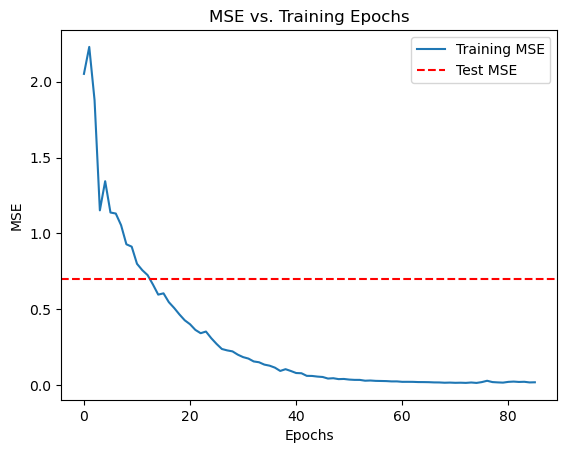

In [266]:
nn_model_loss = nn_model.fit(x_train_scaled, y_train_cs).loss_curve_
mse_test = mean_squared_error(y_test_cs, y_pred_nn)

plt.plot(nn_model_loss, label='Training MSE')
plt.axhline(y=mse_test, color='r', linestyle='--', label='Test MSE') # Reference point
plt.title('MSE vs. Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [267]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

x, y = preprocess_data(training_data)

# setting number of folds and initializing kfold model
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# storing accuracy scores
accuracy_scores = []

# kfold cv loop to store accuracy scores
for train_index, test_index in kf.split(x):
    x_train_kf, x_test_kf = x.iloc[train_index], x.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    # model training
    rf_cs.fit(x_train_kf, y_train_kf)

    # predicting test set
    y_pred_kf = rf_cs.predict(x_test_kf)

    # calculating accuracy scores
    accuracy_kf = accuracy_score(y_test_kf, y_pred_kf)
    accuracy_scores.append(accuracy_kf)

# Calculate the mean and standard deviation of accuracy scores
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

print(f'Mean Accuracy: {mean_accuracy:.2f}')
print(f'Standard Deviation of Accuracy: {std_accuracy:.2f}')


/var/folders/3z/8j8g_lgs5j7b31l1sp39n6380000gn/T/ipykernel_54182/4203988621.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Coach'] = LabelEncoder().fit_transform(data['Coach'])


Mean Accuracy: 0.63
Standard Deviation of Accuracy: 0.04
